In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [5]:
train = pd.read_csv("train.csv", parse_dates = ["datetime"])
train.shape

(10886, 12)

In [6]:
test = pd.read_csv("test.csv", parse_dates = ["datetime"])
test.shape

(6493, 9)

In [7]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
# train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
# train["minute"] = train["datetime"].dt.minute
# train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 16)

In [8]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
# test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
# test["minute"] = test["datetime"].dt.minute
# test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 13)

In [9]:
# 연속형 feature 와 범주형 feature
# 연속형 feature = [ "temp", "humidity", "windspped", "atemp"]
# 범주형 feature의 type을 category로 변경해 준다.
categorical_feature_names = ["season", "holiday", "workingday", "weather", "dayofweek", "month", "year", "hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")
    

In [10]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed", "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [11]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,0.0,2011,0,5,0,0
1,1,1,9.02,13.635,80,0.0,2011,1,5,0,0
2,1,1,9.02,13.635,80,0.0,2011,2,5,0,0
3,1,1,9.84,14.395,75,0.0,2011,3,5,0,0
4,1,1,9.84,14.395,75,0.0,2011,4,5,0,0


In [12]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [15]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [16]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp = True):
    
    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 쒸운다.
    score = np.sqrt(mean_difference)
    
    return score

## 선형회귀 모델 Linear Regression Model

- 선형회귀 또는 최소제곱법은 가장 간단하고 오래된 회귀용 선형 알고리즘
- 선형회귀는 예측과 훈련 세트에 있는 타깃 y사이의 평균제곱오차(MSE)를 최소화하는 파라미터 w와 b를 찾는다.
- 매개변수가 없는 것이 장점이지만, 모델의 복잡도를 제어할 수 없다는 단점이 있다.
- 아래 위키피디아에서 가져온 그래프에서 파란선이 선형회귀 모델을 나타내고 빨간점들이 훈련데이터를 나타낸다.

https://github.com/corazzon/KaggleStruggle/blob/master/bike-sharing-demand/bike-sharing-demand-ensemble-model.ipynb

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category = DeprecationWarning)

# 선형회귀 모델을 초기화
lModel = LinearRegression()

# 모델을 학습시킨다.
y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

# 예측하고 정확도를 평가한다.
preds = lModel.predict(X_train)
print ("RMSLE Value For Linear Regression: ",
      rmsle(np.exp(y_train_log), np.exp(preds), False))

RMSLE Value For Linear Regression:  0.9796533446288513


In [19]:
# 선형회귀 모델을 가져와서 학습 시킨 후 점수를 내보았더니 0.97...

## 릿지 Regularization Model - Ridge

- 회귀를 위한 선형모델
- 가중치(w)의 모든 원소가 0에 가깝게 만들어 모든 피처가 주는 영향을 최소화(기울기를 작게 만듦)
- Regularization(정규화)는 오버피팅(과대적합)이 되지 않도록 모델을 강제로 제한한다는 의미
- max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다. >> 'max_iter' : [3000]

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9796533426169111


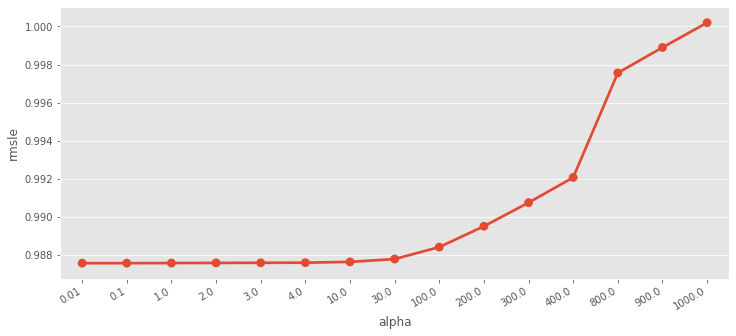

In [36]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000], 'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)
grid_ridge_m = GridSearchCV ( ridge_m_,
                        ridge_params_,
                        scoring = rmsle_scorer,
                        cv = 5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

fig,ax = plt.subplots()
fig.set_size_inches(12,5)

df = pd.DataFrame(grid_ridge_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

# scikit learn이 버전업 되면서 GridSearchCV의 parameter가 변경되었다고한다............
# 그래서 아래 내용 대신 위 3줄로 바꿔서 해야한다.....
# df = pd.DataFrame(grid_ridge_m.grid_scores_)
# df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
# df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df, x="alpha",y="rmsle",ax=ax) 

In [37]:
# 학습 시킨 값을 시간화하고, 값을 확인했을 때
# 최적의 알파값은 0.01이고, 맥스_iteration은 3000번
# 위 학습 결과의 RMSLE 결과는 0.98...

## 라쏘 Regularization Model - Lasso

- 선형회귀의 Regularization(규제)를 적용하는 대안
- 계수를 0에 가깝게 만들려고 하며 이를 L1규제라고 하며, 어떤 계수는 0이 되기도 하는데 이는 완전히 제외하는 피처가 생긴다는 의미다.
- 피처 선택이 자동으로 이루어진다고도 볼 수 있다.
- alpha 값의 기본 값은 1.0이며, 과소 적합을 줄이기 위해서는 이 값을 줄여야 한다.
  (과소적합이 무엇일까?)
- 그리드 서치로 아래 라쏘모델을 실행했을 때 베스트 알파값은 0.0025
- max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

{'alpha': 0.0025, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9796691537976355


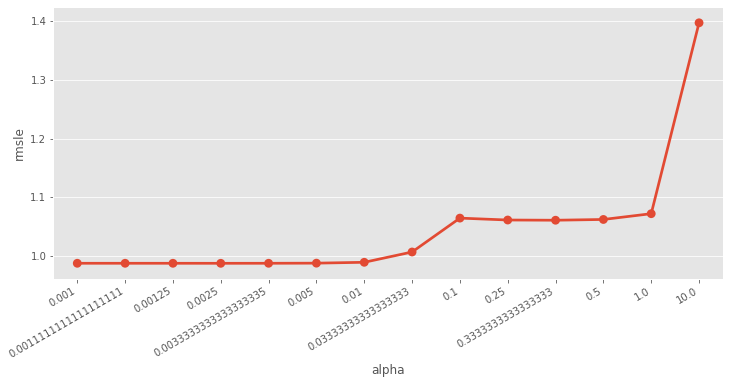

In [40]:
lasso_m_ = Lasso()

alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params_ = { 'max_iter':[3000], 'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

# plt.xticks(rotation = 30, ha = 'right')
# sns.pointplot(data = df, x = "alpha", y = "rmsle", ax = ax)

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

In [41]:
# maybe 버전이 바뀌어서? 영상에서는 최적의 알파값이 0.00125 / RMSLE 결과는 0.980...이었는데
# 위에 내용으로 하면 최적의 알파값이 0.0025 / RMSLE 결과는 0.979...

## 앙상블모델 - 랜덤포레스트

## Eemble Models - Random Forest

In [43]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

RMSLE Value For Random Forest:  0.10656149407406958


## 앙상블모델 - 그라디언트 부스트

## Ensemble Model - Gradient Boost

- 여러개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
- 회귀와 분류에 모두 사용할 수 있음
- 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
- 무작위성이 없고 강력한 사전 가지치기가 사용 됨
- 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
- learning_rate : 오차를 얼마나 강하게 보정할 것인지를 제어
- n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가 되어 모델의 복잡도가 커지고 훈련세트에서의 실수를 바로잡을 기회가 많아지지만 너무 크면 모델이 복잡해지고 오버피팅(과대적합)이 될 수있다.
- max_depth(max_leaf_nodes) 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.

In [44]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.20417262910493975


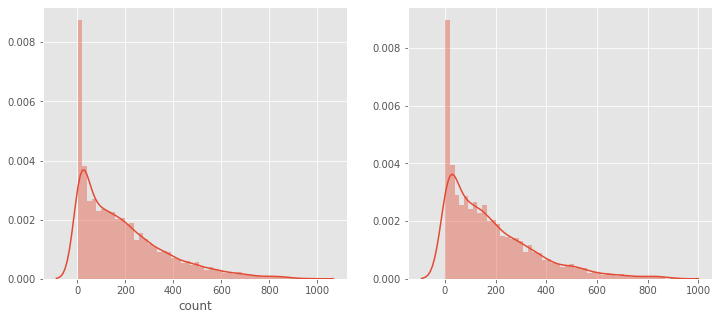

In [46]:
predsTest = rfModel.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)